In [198]:
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import * 
from cleaning import *
from cross_validation import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_path = "data/train.csv"

In [185]:
y, x, ids = load_csv_data(data_path, sub_sample=False)

## Exploratory Data Analysis

All features are numeric. The number of jets is discrete.

#### Distribution of the features
Let's look at the distribution of some of the features.

In [113]:
def plot_histogram(x, col_idx):
    plt.hist(x[:, col_idx], bins=100, log=True)
    
    plt.title(f'Histogram of feature index {col_idx}')
    plt.ylabel('Counts (log scale)')
    plt.xlabel('Values')
    plt.show()

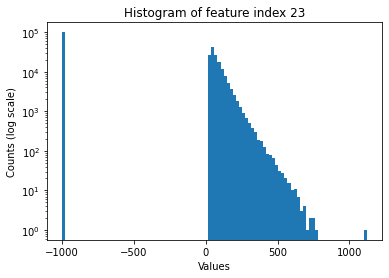

In [156]:
plot_histogram(x, 23)

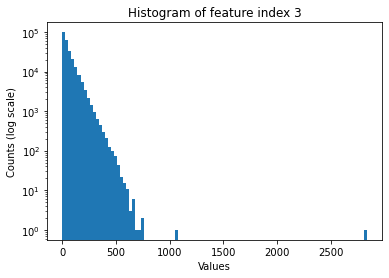

In [115]:
plot_histogram(x, 3)

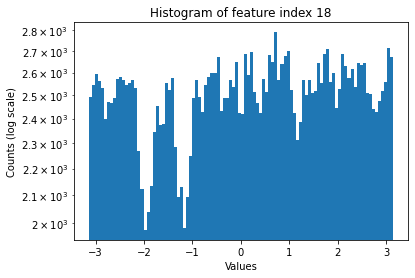

In [116]:
plot_histogram(x, 18)

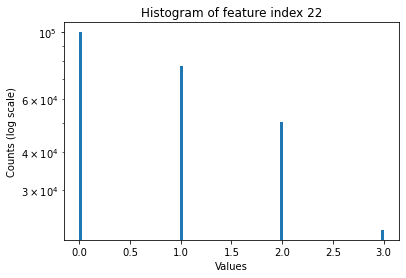

In [117]:
plot_histogram(x, 22)

We can see that some features clearly have default values to -999, some seem to have extreme outliers (e.g. feature 3). We can also check that feature index 22 only has non negative integer values.

#### Check the ranges of some features

In [151]:
# Check if the values for the number of jets are non negative integers
# Column 22 corresponds to this variable
print(f'Number of negative values : {np.sum(x[:, 22] < 0)}')

Number of negative values : 0


Some features represents angles, which are supposed to be in the range $[\pi; -\pi[$ according to the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). Let's check this is the case.

In [160]:
x.shape

(250000, 30)

In [187]:
x_cleaned = x.copy()
x_cleaned = check_azimuth_and_rerange(x_cleaned, 15)
x_cleaned = check_azimuth_and_rerange(x_cleaned, 18)
x_cleaned = check_azimuth_and_rerange(x_cleaned, 20)
x_cleaned = check_azimuth_and_rerange(x_cleaned, 25)
x_cleaned = check_azimuth_and_rerange(x_cleaned, 28)

Number of values outside [-pi;pi[ (col 15): 9
Number of values outside [-pi;pi[ (col 18): 11
Number of values outside [-pi;pi[ (col 20): 9
Number of values outside [-pi;pi[ (col 25): 99916
Number of values outside [-pi;pi[ (col 28): 177461


We can see that some of the features have rows with azimuth outside the range. For these features indexes we deciced to put the non-valid values back in the $[-\pi; \pi[$ interval by taking the modulo $2 \pi$ and subtracting $\pi$.

In [188]:
np.sum(x_cleaned == -999, axis=0)

array([ 38114,      0,      0,      0, 177457, 177457, 177457,      0,
            0,      0,      0,      0, 177457,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  99913,
        99913,      0, 177457, 177457,      0,      0])

We can see that some of the features have a very high number of undefined values (-999). We could replace this undefined values by e.g. 0 or the mean of the remaining values but this would result in columns having its majority of entries (e.g. 177'000 / 250'000 $\approx$ 0.7) at the same value. This would imply that there is not a lot of variance in the feature and therefore this does not give much information about the label we want to predict. So we decided to drop the features where more than half of the rows are at -999.

In [199]:
# We remove the features where more than half of the rows are -999
x_cleaned = remove_col_default_values(x_cleaned)

NameError: name 'remove_col_default_values' is not defined

We also looked if some rows were having more than half of its features set to a default value (i.e. -999). In this case, there were no such rows.

In [200]:
check_nb_rows_default_features(x_cleaned)

NameError: name 'check_nb_rows_default_features' is not defined

For the remaining default values, we decided to set them to -999. We did this instead of e.g. replacing them by the mean or median of the remaining values because we noted that the models actually performed better.

In [194]:
# Replace the remaining -999 by the median/mean/0s
def check_
for i in range(x_cleaned.shape[1]):
    mask = x_cleaned[:, i] == -999
    x_cleaned[mask, i] = np.median(x_cleaned[~mask, i]) # or 0

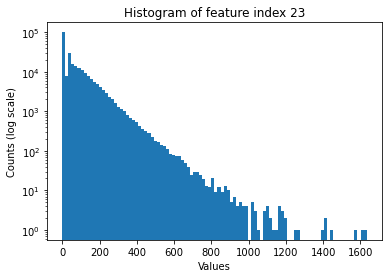

In [196]:
plot_histogram(x_cleaned, 23)

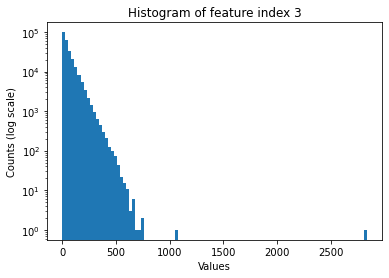

In [197]:
plot_histogram(x_cleaned, 3)

#### Removing outliers
We can observe that in some features there still seems to be some outliers (e.g. see the histogram above for feature index 3).


We will deal with them using a method based on the Inter Quartile Range (IQR). 

In [1]:
def percentile_comparison(row, above_lim, below_lim) :
    for idx, percs in enumerate(zip(above_lim, below_lim)) :
        if row[idx] > percs[0] :
            row[idx] = percs[0]
        if row[idx] < percs[1] :
            row[idx] = percs[1]
    return row

def clip_IQR(x, k=1.5, percentiles=[25, 75]):
    perc = np.percentile(x_cleaned, percentiles, axis=0)
    
    iqr = (perc[1,:]-perc[0,:])
    above_lim = perc[1,:] + k * irq
    below_lim = perc[0,:] - k * irq
    
    x = np.apply_along_axis(lambda row : percentile_comparison(row, above_lim, below_lim),
                           1, x_cleaned)
    
    return x

x_cleaned = clip_IQR(x_cleaned, k=3)

NameError: name 'x_cleaned' is not defined

In [135]:
acc_local_test, w_best = run_experiment(y, x_cleaned, 'reg_logistic_regression', 1, 0.8)

KeyboardInterrupt: 

In [31]:
acc_local_test, w_best = run_experiment(y, x_rem, 'ridge_regression', 1, 0.8)

Accuracy of ridge_regression on the local test set : 0.7270


In [ ]:
test_path = 'data/test.csv'

y_test, x_test, ids_test = load_csv_data(test_path)
x_test, mean_x_test, std_x_test = standardize(x_test)
y_test_pred = predict_labels_logistic_regression(w_cv, x_test)
y_test_pred = predict_labels(w_best, x_test)
create_csv_submission(ids_test, y_test_pred, 'ridge.csv')

## Work on logistic regression